## Project Idea:
For new graduates and starters, job seeking are always confusing. The skills required at job market are not taught in school. 
Therefore, we want to come up with a wordcloud (most frequently wanted skills/tech stack) for each type of IT job. Having this 
as a reference, job seekers can have a more targeted preparation for the market. For those whose skill sets have already some overlapping with the market need, they can feed our wordcloud and their original cover letter to gpt to write a cover letter that has higher chance to pass the Application Tracking System

In [195]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

### Load the Netherlands job posting dataset

In [174]:
df_NL = pd.read_csv('/kaggle/input/sourcestack-data-nl-shesharpcsv/sourcestack-data-NL.csv')


In [175]:
df_NL

,job_name,hours,department,seniority,remote,company_name,company_url,post_url,tags_matched,tag_categories,job_location,city,region,country,last_indexed
0,Salesforce Service Cloud Admin (32-40uur/Hybri...,NaN,NaN,NaN,NaN,Create Your Own Career,createyourowncareer.com,career5.successfactors.eu/career?career_ns=job...,"[Ad Alliance, RTL Group, Salesforce Service Cl...","[Call Center Tools, Project Management, Compli...",Netherlands,NaN,NaN,Netherlands,2023-05-31 13:35:20
1,PLC Engineer,NaN,NaN,NaN,NaN,Ranpak,ranpak.com,recruitingbypaycor.com/career/JobIntroduction....,[Siemens],"[Applications - Industry, Industrial]","Kerkrade, Netherlands",Kerkrade,NaN,Netherlands,2023-05-20 05:51:38
2,Commissioning engineer propulsion (36710),Commission,NaN,NaN,NaN,Wartsila,wartsila.com,career2.successfactors.eu/career?career_ns=job...,[],[],Service Delivery,NaN,NaN,Netherlands,2023-05-31 02:14:18
3,Quality Assurance Engineer,Full-Time,Engineering,NaN,NaN,Fluke,fortive.com,fortive.taleo.net/careersection/external/jobde...,"[Oracle, Excel, Microsoft]","[FP&A, Spreadsheets, Databases, Accounting, Da...",Europe - Netherlands - North Brabant - Eindhoven,Eindhoven,NaN,Netherlands,2023-05-20 05:24:04
4,Support Engineer I - Europe,NaN,NaN,NaN,True,ClickHouse,clickhouse.com,boards.greenhouse.io/clickhouse/jobs/4891900004,"[Kubernetes, Slack, Cisco, Linux, Uber, Linked...","[OS, Data Science Tools, Messaging, Databases,...",Netherlands,Amsterdam,New Hampshire,Netherlands,2023-06-07 09:22:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Supply Chain Improvement Program Manager,Full-Time,NaN,Manager,NaN,NL3M Philips International,philips.com,philips.wd3.myworkdayjobs.com/internal-job-pos...,[Workday],"[Human Resources, Enterprise Customers, Back O...",Best - QG,NaN,NaN,Netherlands,2023-06-08 15:27:41
496,Agile Product Owner - Software system engineer,Contract,NaN,NaN,False,NaN,NaN,apply.workable.com/belmont-lavan-ltd/j/99D1769B30,[],[],NaN,Hengelo,Overijssel,Netherlands,2023-05-26 10:48:15
497,Network Engineer Senior,Full-Time,Technology,NaN,NaN,Macatawa Bank Opportunities,macatawabank.com,recruiting.ultipro.com/mac1007/jobboard/e7e290...,"[Microsoft, Citrix, Cisco, Windows Server, VMW...","[Password Managers, CDN, IaaS, Hosting, Securi...",NaN,Holland,Michigan,United States,2023-06-05 21:41:36
498,(Junior) Supply Chain Engineer - Warehouse Aut...,Full-Time,Automation,Junior IC,NaN,Ranpak,ranpak.com,recruiting.ultipro.com/ran1006ranp/jobboard/16...,"[Sigma, SAP, Misfit]","[Payments, FP&A, SaaS, Servers & Compute, Serv...",NaN,Heerlen,Netherlands,Netherlands,2023-06-06 09:56:40


### Clean the Data
To do fuzzy matching for job name, we normalize the job name column by converting to lower case, removing tabulation, punctuation, and special characters.

In [176]:
## Lower case
df_NL['job_name'] = df_NL['job_name'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
df_NL['job_name'] = df_NL['job_name'].str.replace('[^\w\s]',' ')
## digits
df_NL['job_name'] = df_NL['job_name'].str.replace('\d+', '')
## remove -
df_NL['job_name'] = df_NL['job_name'].str.replace('-', '')

/tmp/ipykernel_32/2132299773.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_NL['job_name'] = df_NL['job_name'].str.replace('[^\w\s]',' ')
/tmp/ipykernel_32/2132299773.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_NL['job_name'] = df_NL['job_name'].str.replace('\d+', '')


In [177]:
df_NL['job_name'] = df_NL['job_name'].str.replace('  ', ' ')
df_NL['job_name'] = df_NL['job_name'].str.replace('\n', ' ')

### URL Prefix Addition
We want to get job descriptions from job posting URL in the future, therefore we add `https://` as prefix for all the url strings

In [178]:
df_NL['prefix']="https://"
df_NL["prefix_url"]=df_NL[["prefix","post_url"]].agg(''.join, axis=1)
df_NL.drop(columns=['prefix', 'post_url'], inplace=True)

For this analysis, we ended up not using the url for scraping job description because a lot of url turns out to have "this job no longer exist". In the future if we are working with up-to-date (streaming) job posting, this will be very useful


## Clean data

We remove `[]` from the `tags_matched` and `tag_categories`. We replace `NaN` for blanks cells.



In [179]:
df_NL['tags_matched'] = df_NL['tags_matched'].str.strip("[]")
df_NL['tag_categories'] = df_NL['tag_categories'].str.strip("[]")
df_NL = df_NL.replace(r'^\s*$', np.nan, regex=True)

### Categorize 
We filtered top 30 jobs in order to categorize jobs.

In [180]:
top_30_jobs = df_NL['job_name'].value_counts().head(30).index.tolist()
top_30_data = df_NL[df_NL['job_name'].isin(top_30_jobs)]

filtered_data = top_30_data.drop_duplicates()
filtered_data.to_csv('filtered_dataset.csv', index=False)

We find the 12 "most common" tech jobs, parsing each of them into a pandas dataframe

In [181]:
data_engineer_nl = df_NL[df_NL['job_name'].str.contains("data engineer")]
frontend_nl = df_NL[df_NL['job_name'].str.contains("frontend")]
backend_nl = df_NL[df_NL['job_name'].str.contains("backend")]
data_analyst_nl = df_NL[df_NL['job_name'].str.contains("data analyst")]
data_scientist_nl = df_NL[df_NL['job_name'].str.contains("data scientist")]
full_stack_nl = df_NL[df_NL['job_name'].str.contains("full stack|fullstack")]
product_manager_nl = df_NL[df_NL['job_name'].str.contains("product manager")]
product_owner_nl = df_NL[df_NL['job_name'].str.contains("product owner")]
quality_nl = df_NL[df_NL['job_name'].str.contains("quality")]
support_nl = df_NL[df_NL['job_name'].str.contains("support")]
devops_nl = df_NL[df_NL['job_name'].str.contains("devops")]
security_engineer_nl = df_NL[df_NL['job_name'].str.contains("security engineer")]

In [182]:
csv = [data_engineer_nl,frontend_nl,backend_nl,data_analyst_nl,data_scientist_nl,full_stack_nl,product_manager_nl, product_owner_nl, quality_nl, support_nl,devops_nl,security_engineer_nl]


In [183]:
role_names = "data_engineer_nl, frontend_nl, backend_nl, data_analyst_nl, data_scientist_nl, full_stack_nl, product_manager_nl, product_owner_nl, quality_nl, support_nl, devops_nl, security_engineer_nl".split(", ")

In [184]:
role_names


['data_engineer_nl',
 'frontend_nl',
 'backend_nl',
 'data_analyst_nl',
 'data_scientist_nl',
 'full_stack_nl',
 'product_manager_nl',
 'product_owner_nl',
 'quality_nl',
 'support_nl',
 'devops_nl',
 'security_engineer_nl']

Now we define a function that removes common English words and punctuation from tags and job descriptions

In [185]:
stop_words = stopwords.words('english')
stop_words.extend(['tools'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    word_tokens = word_tokenize(text)

    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


Now we create a word cloud for each of the 12 job titles, highlighting the most wanted skills and tech stack

Our original data set for data_engineer_nl has 17 entries
After cleaning, we are working with 17 entries


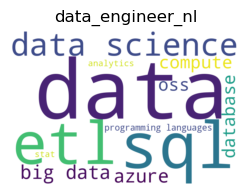

Our original data set for frontend_nl has 12 entries
After cleaning, we are working with 12 entries


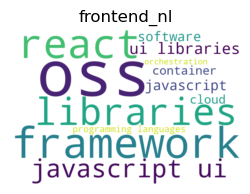

Our original data set for backend_nl has 17 entries
After cleaning, we are working with 17 entries


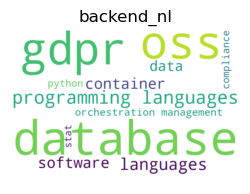

Our original data set for data_analyst_nl has 9 entries
After cleaning, we are working with 9 entries


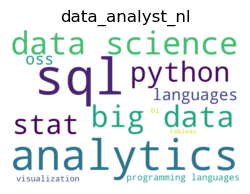

Our original data set for data_scientist_nl has 11 entries
After cleaning, we are working with 9 entries


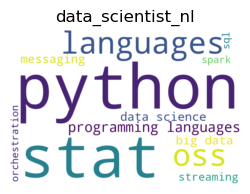

Our original data set for full_stack_nl has 13 entries
After cleaning, we are working with 12 entries


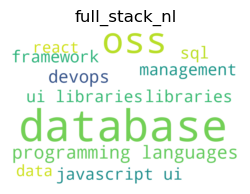

Our original data set for product_manager_nl has 20 entries
After cleaning, we are working with 13 entries


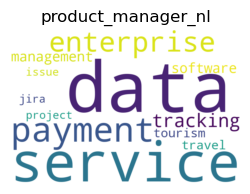

Our original data set for product_owner_nl has 15 entries
After cleaning, we are working with 8 entries


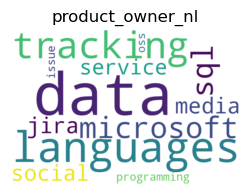

Our original data set for quality_nl has 15 entries
After cleaning, we are working with 6 entries


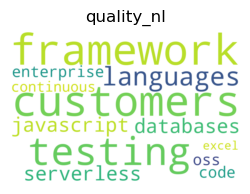

Our original data set for support_nl has 12 entries
After cleaning, we are working with 8 entries


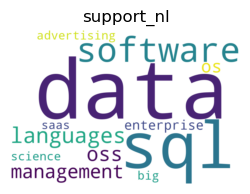

Our original data set for devops_nl has 13 entries
After cleaning, we are working with 13 entries


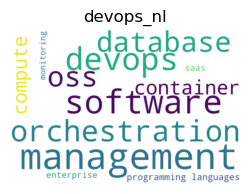

Our original data set for security_engineer_nl has 8 entries
After cleaning, we are working with 4 entries


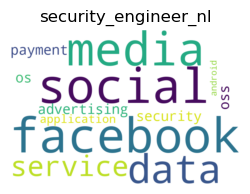

In [186]:
for role, role_name in zip(csv, role_names):
    role_pd = role[["tags_matched", "tag_categories"]].dropna()
    print("Our original data set for " + role_name + " has " + str(len(role)) + " entries")
    print("After cleaning, we are working with %d entries" %len(role_pd) )
    
    list_desc = ' '.join(role_pd.tags_matched.tolist() + 
                     role_pd.tag_categories.tolist())
    
    words_filtered = punctuation_stop(list_desc)

    text = " ".join([ele for ele in words_filtered])
    wc= WordCloud(background_color="white", random_state=1,stopwords=stop_words, max_words = 12, width =900, height = 600)
    wc.generate(text)

    plt.figure(figsize=[3,2])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis('off')
    plt.title(role_name)
    plt.show()